## Import packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xesmf as xe
import numpy as np
import geopandas as gpd
import shapely.geometry as geom
import matplotlib.gridspec as gridspec

## Load data 

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'stratiform_rainfall_flux'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable]

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable]

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')[variable]

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')[variable]

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')[variable]

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')[variable]

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')[variable]

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')[variable]


In [3]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

## Land only, sum to daily totals

In [21]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

In [22]:
#sum to total rainfall over time series
allvar_total = (allvar * 3600).sum(dim="time", skipna=True)
control_total = (control * 3600).sum(dim="time", skipna=True)
albedo_bare_total = (albedo_bare * 3600).sum(dim="time", skipna=True)
albedo_total = (albedo * 3600).sum(dim="time", skipna=True)
bare_total = (bare * 3600).sum(dim="time", skipna=True)
SM_albedo_total = (SM_albedo * 3600).sum(dim="time", skipna=True)
SM_bare_total = (SM_bare  * 3600).sum(dim="time", skipna=True)
SM_total = (SM * 3600).sum(dim="time", skipna=True)

In [23]:
experiments = {
    "All variables": allvar,
    "Control": control,
    "Albedo + bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + albedo": SM_albedo,
    "SM + bare": SM_bare,
    "SM": SM
}

#convert to AEST
for name, da in experiments.items():
    da = da.assign_coords(time=da.time + pd.Timedelta(hours=10))
    experiments[name] = da

In [24]:
#defining events
event_windows = {
    "Convective Event (16–18 Jan)": (
        np.datetime64("2020-01-16T00:00"),
        np.datetime64("2020-01-18T23:59")
    ),
    "East Coast Low (8–10 Feb)": (
        np.datetime64("2020-02-08T00:00"),
        np.datetime64("2020-02-10T23:59")
    ),
}

ref_name = "Control"
events_total = {}

#loop through both events and get totals for the event
for event_name, (start, end) in event_windows.items():
    totals = {}
    for name, da in experiments.items():
        #select event
        da_event = da.sel(time=slice(start, end))
        #convert to mm/h
        total = (da_event * 3600).sum(dim="time", skipna=True)
        totals[name] = total
    events_total[event_name] = totals


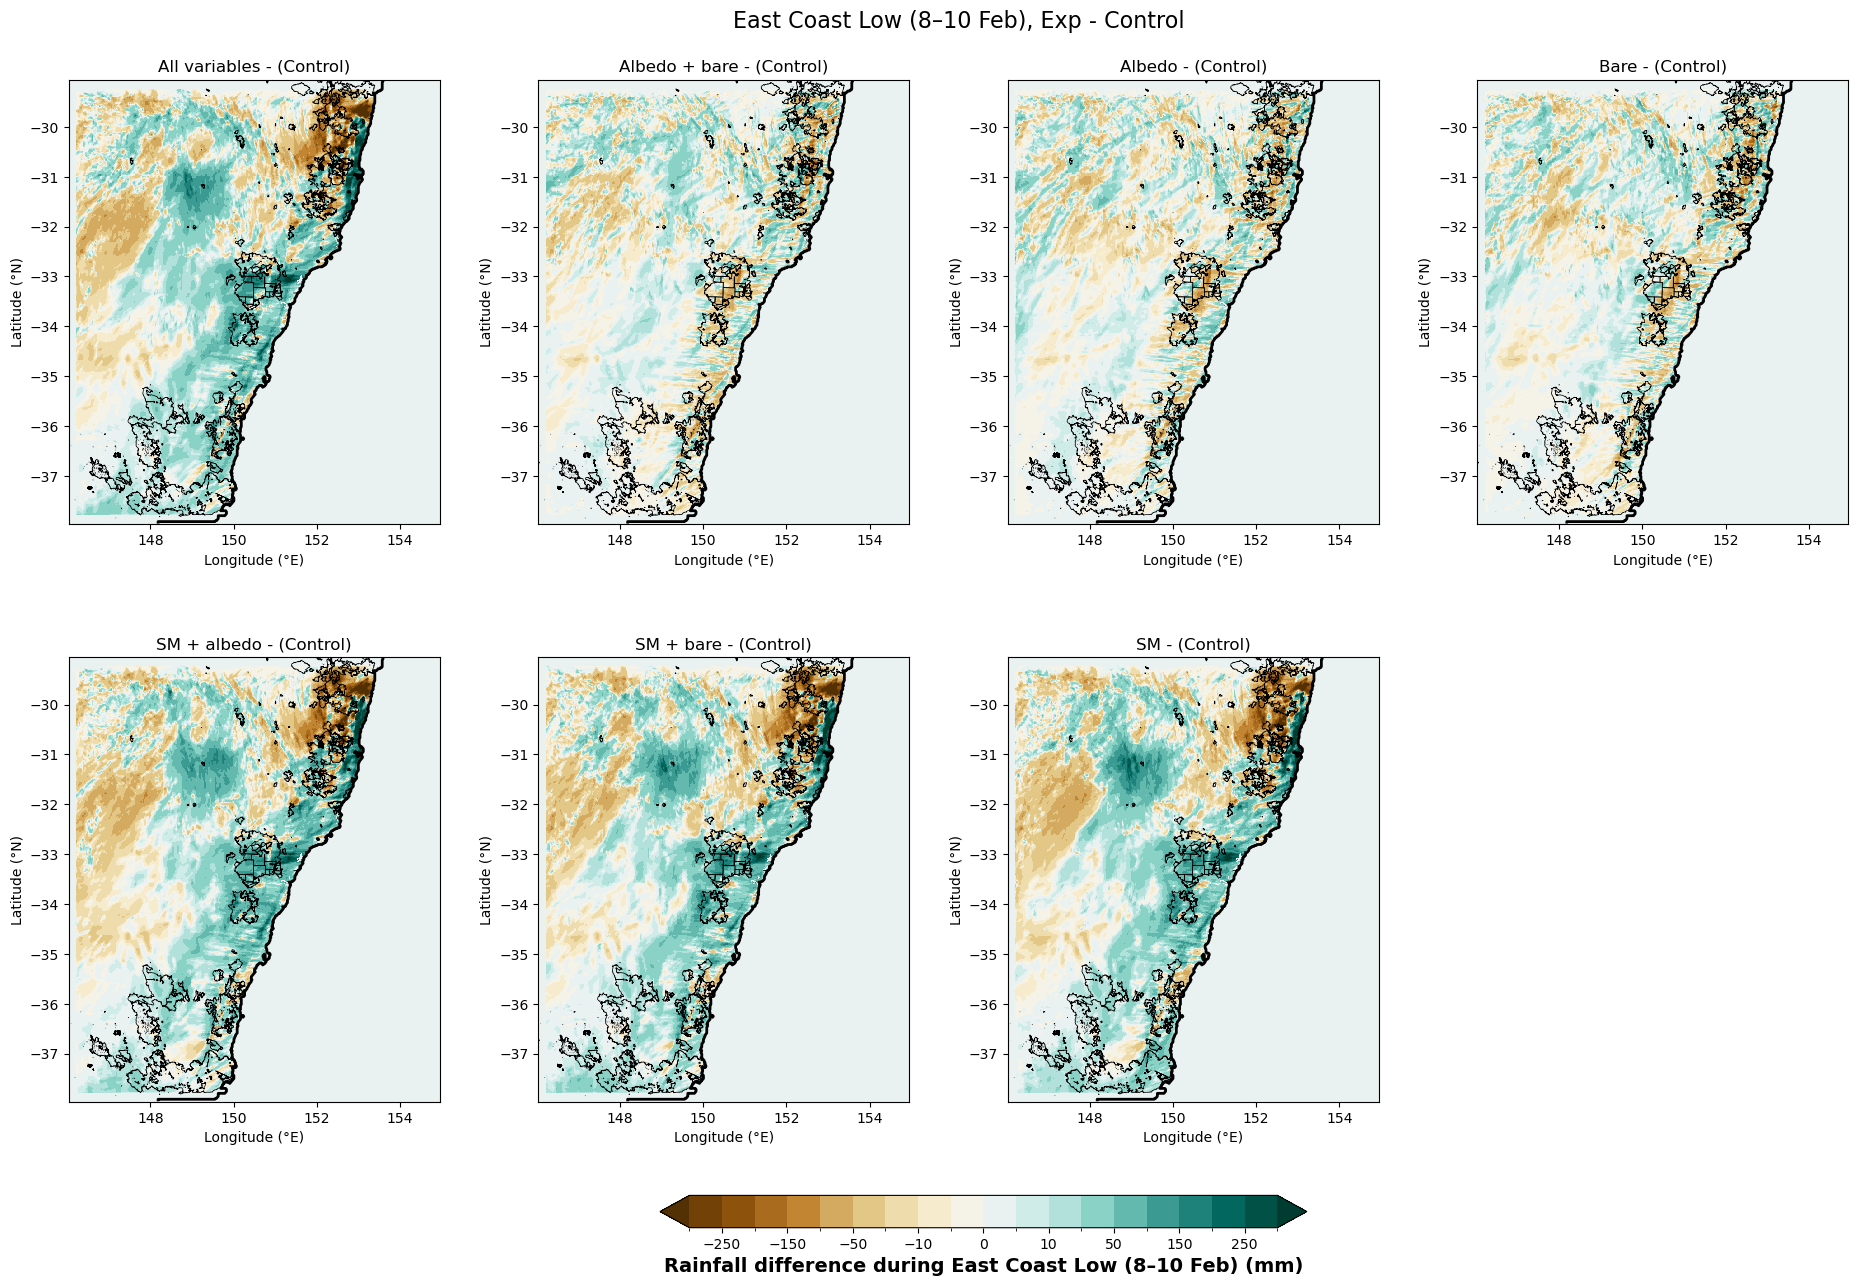

In [25]:
#uncomment appropriate 'levels' dependent on which event is selected

#feb
levels = [-300,-250, -200, -150,-100, -50, -20, -10, -5, 0, 5, 10, 20, 50, 100,150,200, 250, 300] #feb
#jan
# levels = [-100,-50, -20, -10, -5, 0, 5, 10, 20, 50, 100] #jan

#SELECT EVENT, UNCOMMENT 
for event_name, totals in events_total.items():
    if event_name != "East Coast Low (8–10 Feb)":
    # if event_name !="Convective Event (16–18 Jan)":
        continue

    names = list(totals.keys())
    ref_name = "Control"
    
    ncols, nrows = 4, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
    axes = axes.flatten()
    
    plot_idx = 0
    cbar_ax = None
    
    for name in names:
        if name == ref_name:
            continue

        diff = totals[name] - totals[ref_name]
        ax = axes[plot_idx]

        mesh = diff.plot(
            ax=ax,
            cmap="BrBG",
            center=0,
            levels = levels,
            extend="both",
            add_colorbar=False
        )
        if plot_idx == 0:
            cbar_ax = mesh

        sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
        gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

        ax.set_title(f"{name} - ({ref_name})")
        ax.set_xlabel("Longitude (°E)", fontsize=10)
        ax.set_ylabel("Latitude (°N)", fontsize=10)

        plot_idx += 1

    #remove unused 8th
    for j in range(plot_idx, len(axes)):
        fig.delaxes(axes[j])

    # shared colorbar
    cbar= fig.colorbar(
        cbar_ax, ax=axes[:plot_idx],
        orientation='horizontal',
        fraction=0.03, pad=0.02)
    cbar.set_label(f"Rainfall difference during {event_name} (mm)", fontsize=14, fontweight = 'bold')

    fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)
    fig.suptitle(f"{event_name}, Exp - {ref_name}", fontsize=16)
    plt.show()

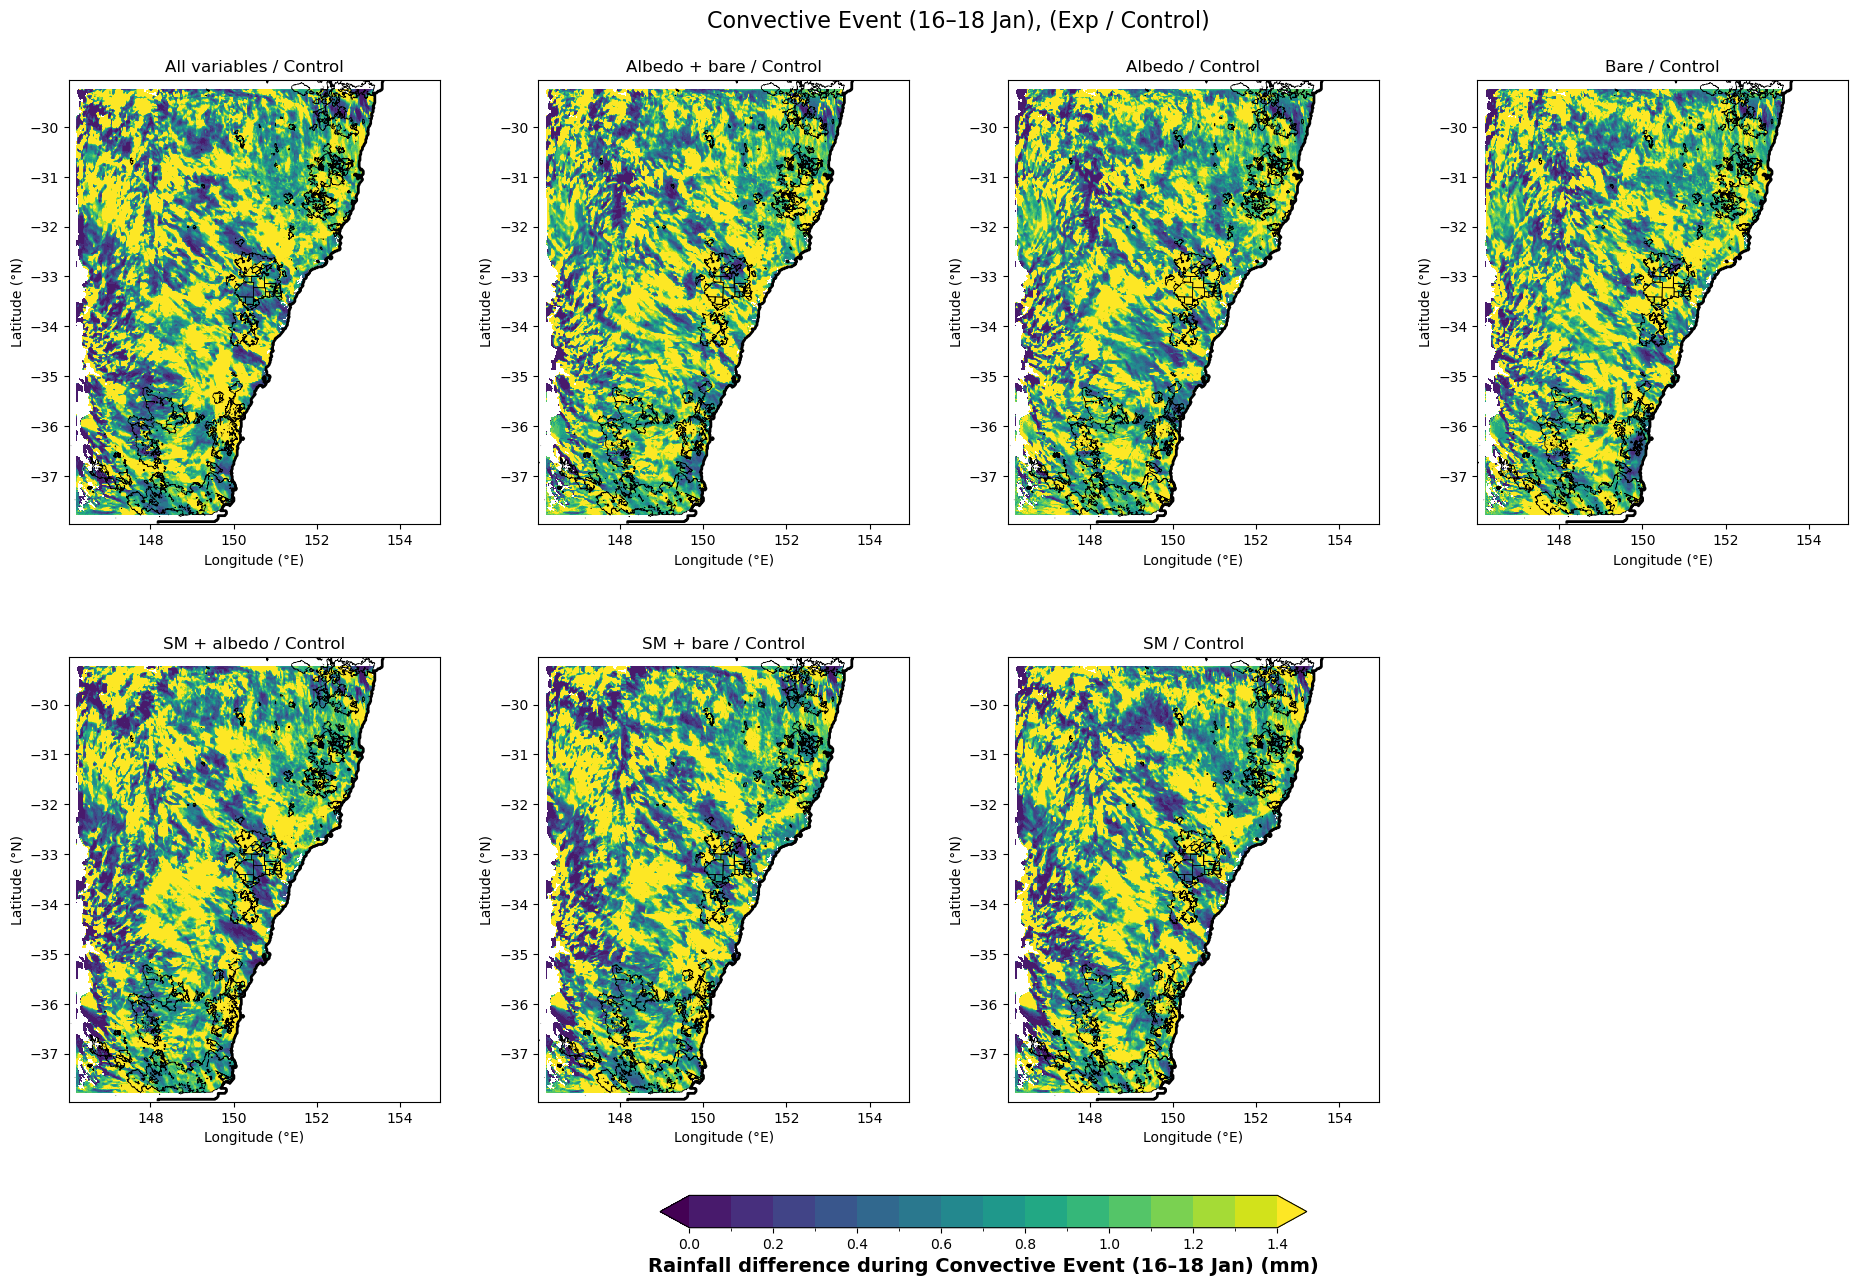

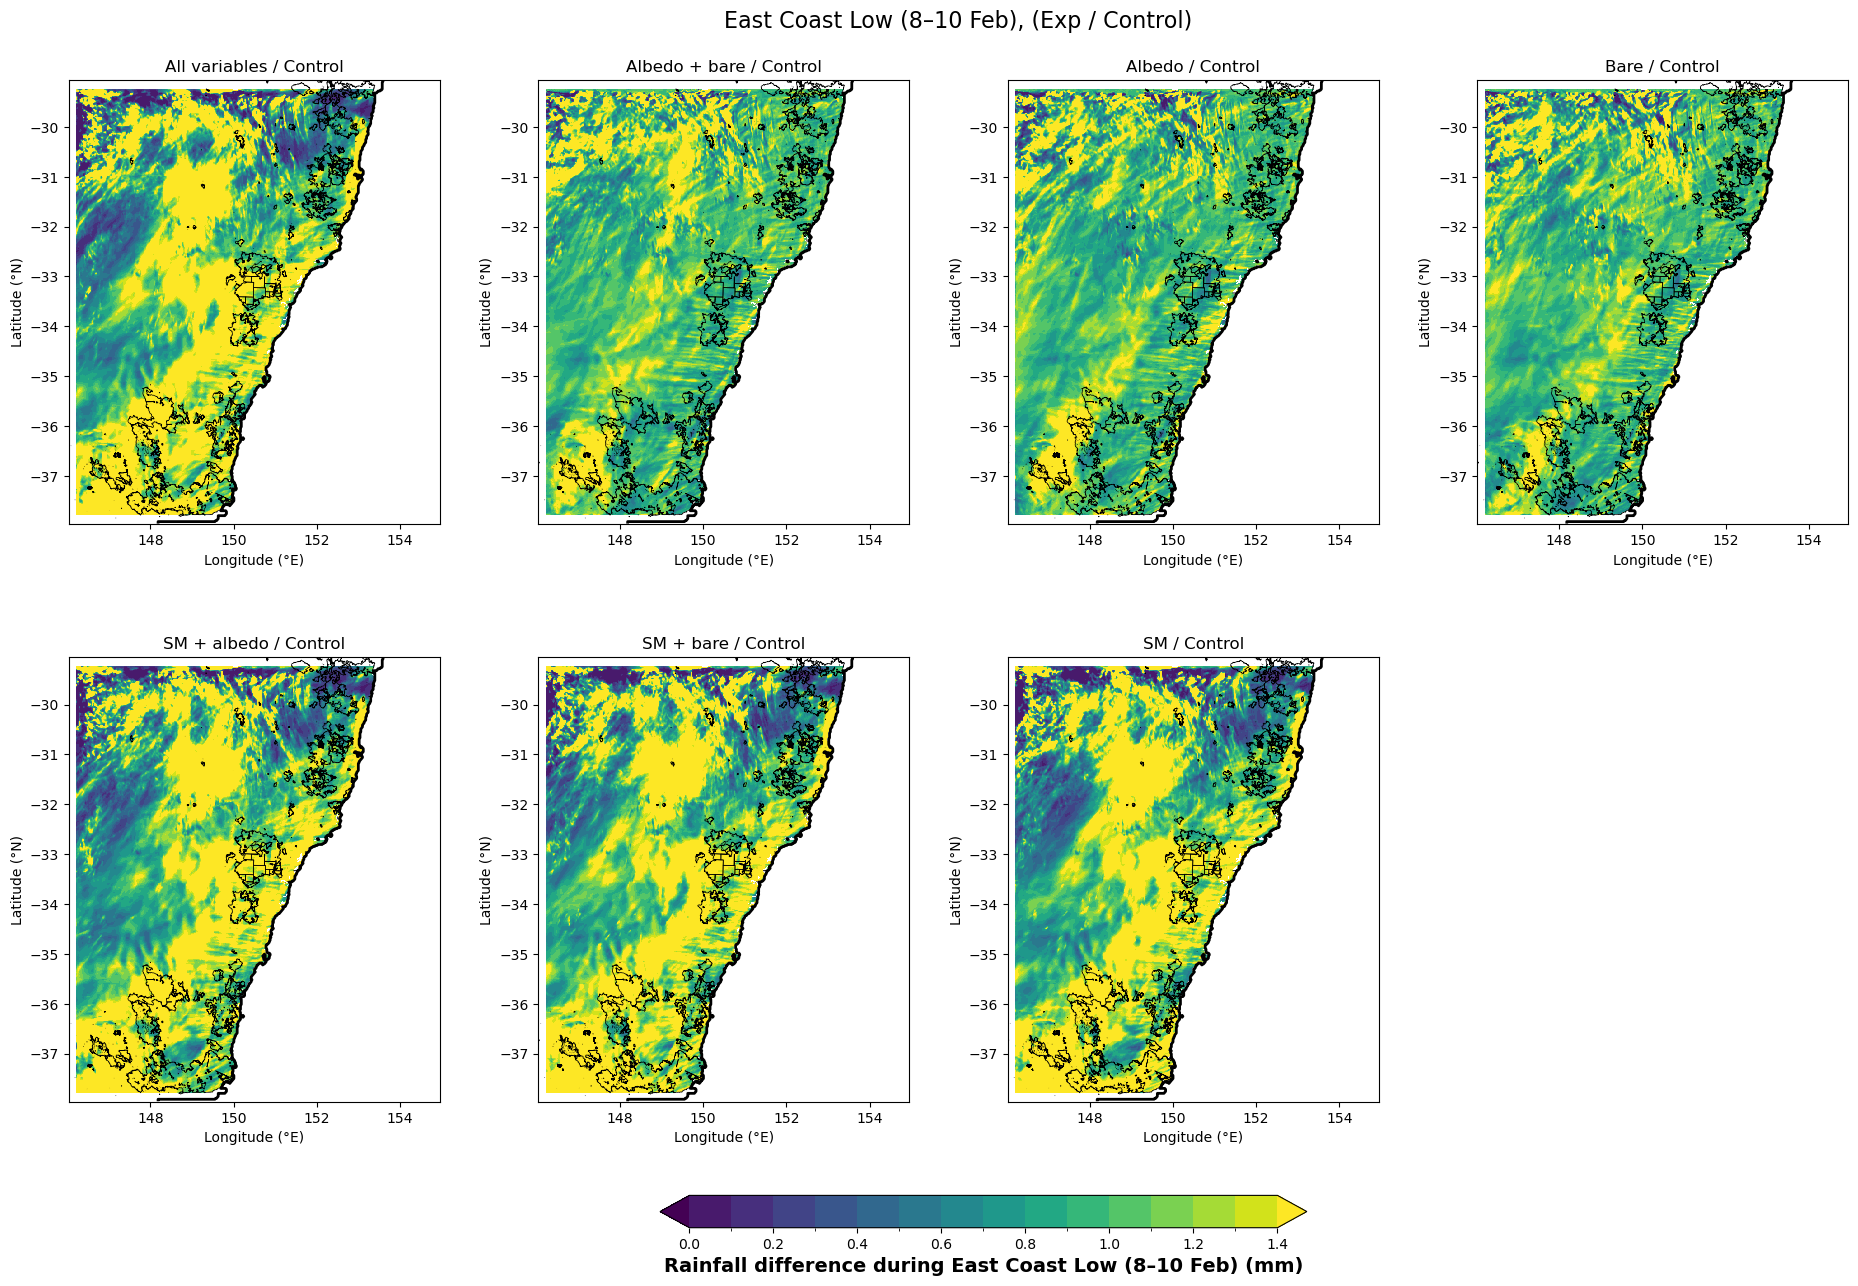

In [10]:
levels = np.arange(0,1.5,0.1)
for event_name, totals in events_total.items():
    names = list(totals.keys())
    ref_name = "Control"
    
    ncols, nrows = 4, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
    axes = axes.flatten()
    
    plot_idx = 0
    cbar_ax = None
    
    for name in names:
        if name == ref_name:
            continue

        diff = totals[name] / totals[ref_name]
        ax = axes[plot_idx]

        mesh = diff.plot(
            ax=ax,
            cmap="viridis",
            center=0,
            levels=levels,
            extend="both",
            add_colorbar=False
        )
        if plot_idx == 0:
            cbar_ax = mesh

        sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
        gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

        ax.set_title(f"{name} / {ref_name}")
        ax.set_xlabel("Longitude (°E)", fontsize=10)
        ax.set_ylabel("Latitude (°N)", fontsize=10)

        plot_idx += 1

    # remove unused axes
    for j in range(plot_idx, len(axes)):
        fig.delaxes(axes[j])

    # shared colorbar
    cbar= fig.colorbar(
        cbar_ax, ax=axes[:plot_idx],
        orientation='horizontal',
        fraction=0.03, pad=0.02,
        label=f"Rainfall difference during {event_name} (mm)"
    )
    cbar.set_label(f"Rainfall difference during {event_name} (mm)", fontsize=14, fontweight = 'bold')

    fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)
    fig.suptitle(f"{event_name}, (Exp / {ref_name})", fontsize=16)
    plt.show()

## Difference plots, entire period

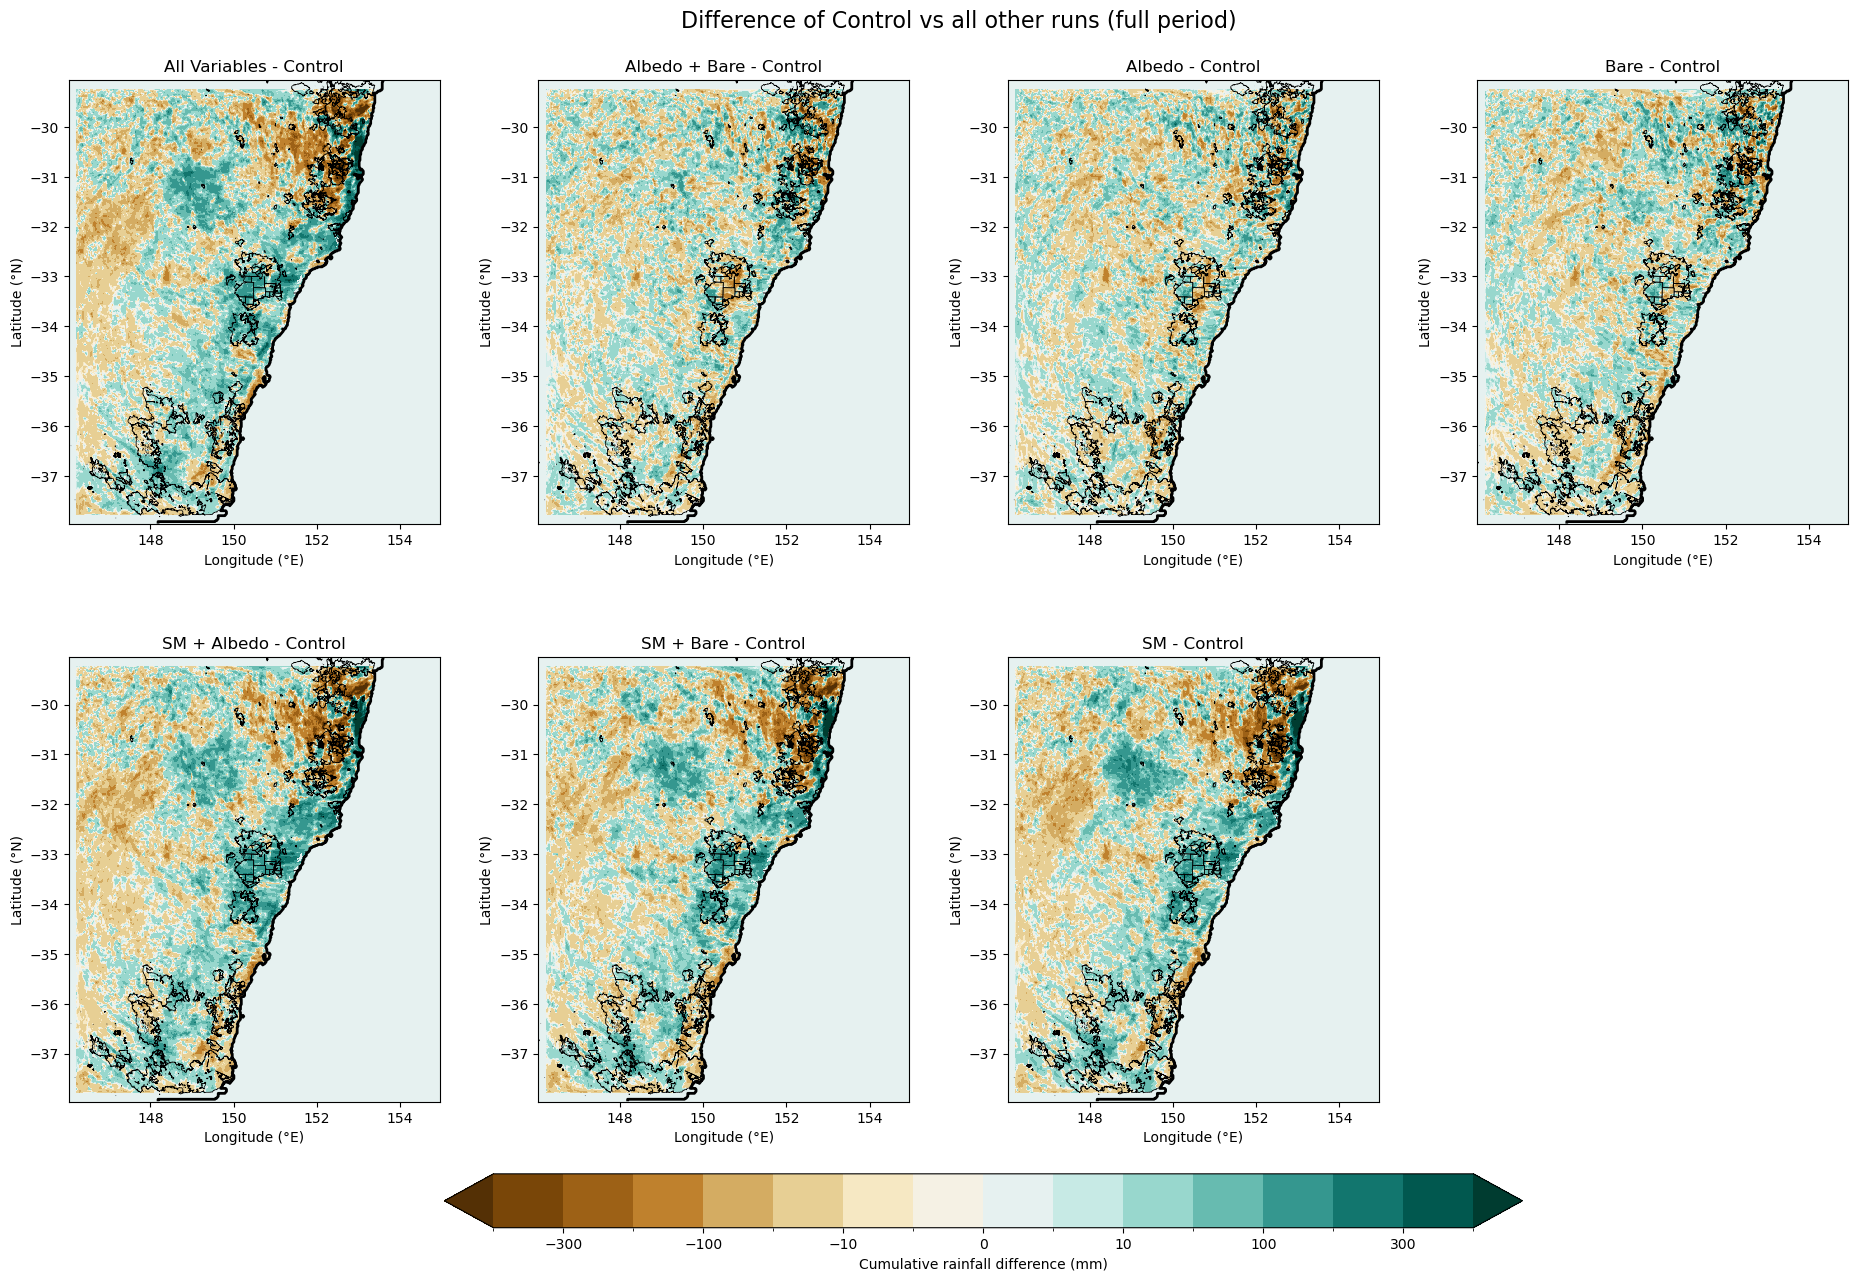

In [11]:
totals = {
    "All Variables": allvar_total,
    "Control": control_total,
    "Albedo + Bare": albedo_bare_total,
    "Albedo": albedo_total,
    "Bare": bare_total,
    "SM + Albedo": SM_albedo_total,
    "SM + Bare": SM_bare_total,
    "SM": SM_total,
}

names = list(totals.keys())
ref_index = 1 #index of ref, 0 = allvar
ref_name = names[ref_index]

ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
axes = axes.flatten()

plot_idx = 0
cbar_ax = None 

for i, name in enumerate(names):
    if i == ref_index:
        continue  #skip reference 

    diff = totals[name] - totals[ref_name] 
    ax = axes[plot_idx]

    mesh = diff.plot(
        ax=ax,
        cmap="BrBG",
        center=0,
        levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
        extend="both",
        add_colorbar=False
    )

    if plot_idx == 0:
        cbar_ax = mesh 

    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.set_title(f"{name} - {ref_name}")
    ax.set_xlabel("Longitude (°E)", fontsize=10)
    ax.set_ylabel("Latitude (°N)", fontsize=10)

    plot_idx += 1

#remove unused axis
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

#shared colorbar along the bottom
fig.colorbar(
    cbar_ax, ax=axes[:plot_idx],
    orientation='horizontal',
    fraction=0.05,
    pad=0.02,       
    label="Cumulative rainfall difference (mm)"
)

#adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)

fig.suptitle(f"Difference of {ref_name} vs all other runs (full period)", fontsize=16)
plt.show()


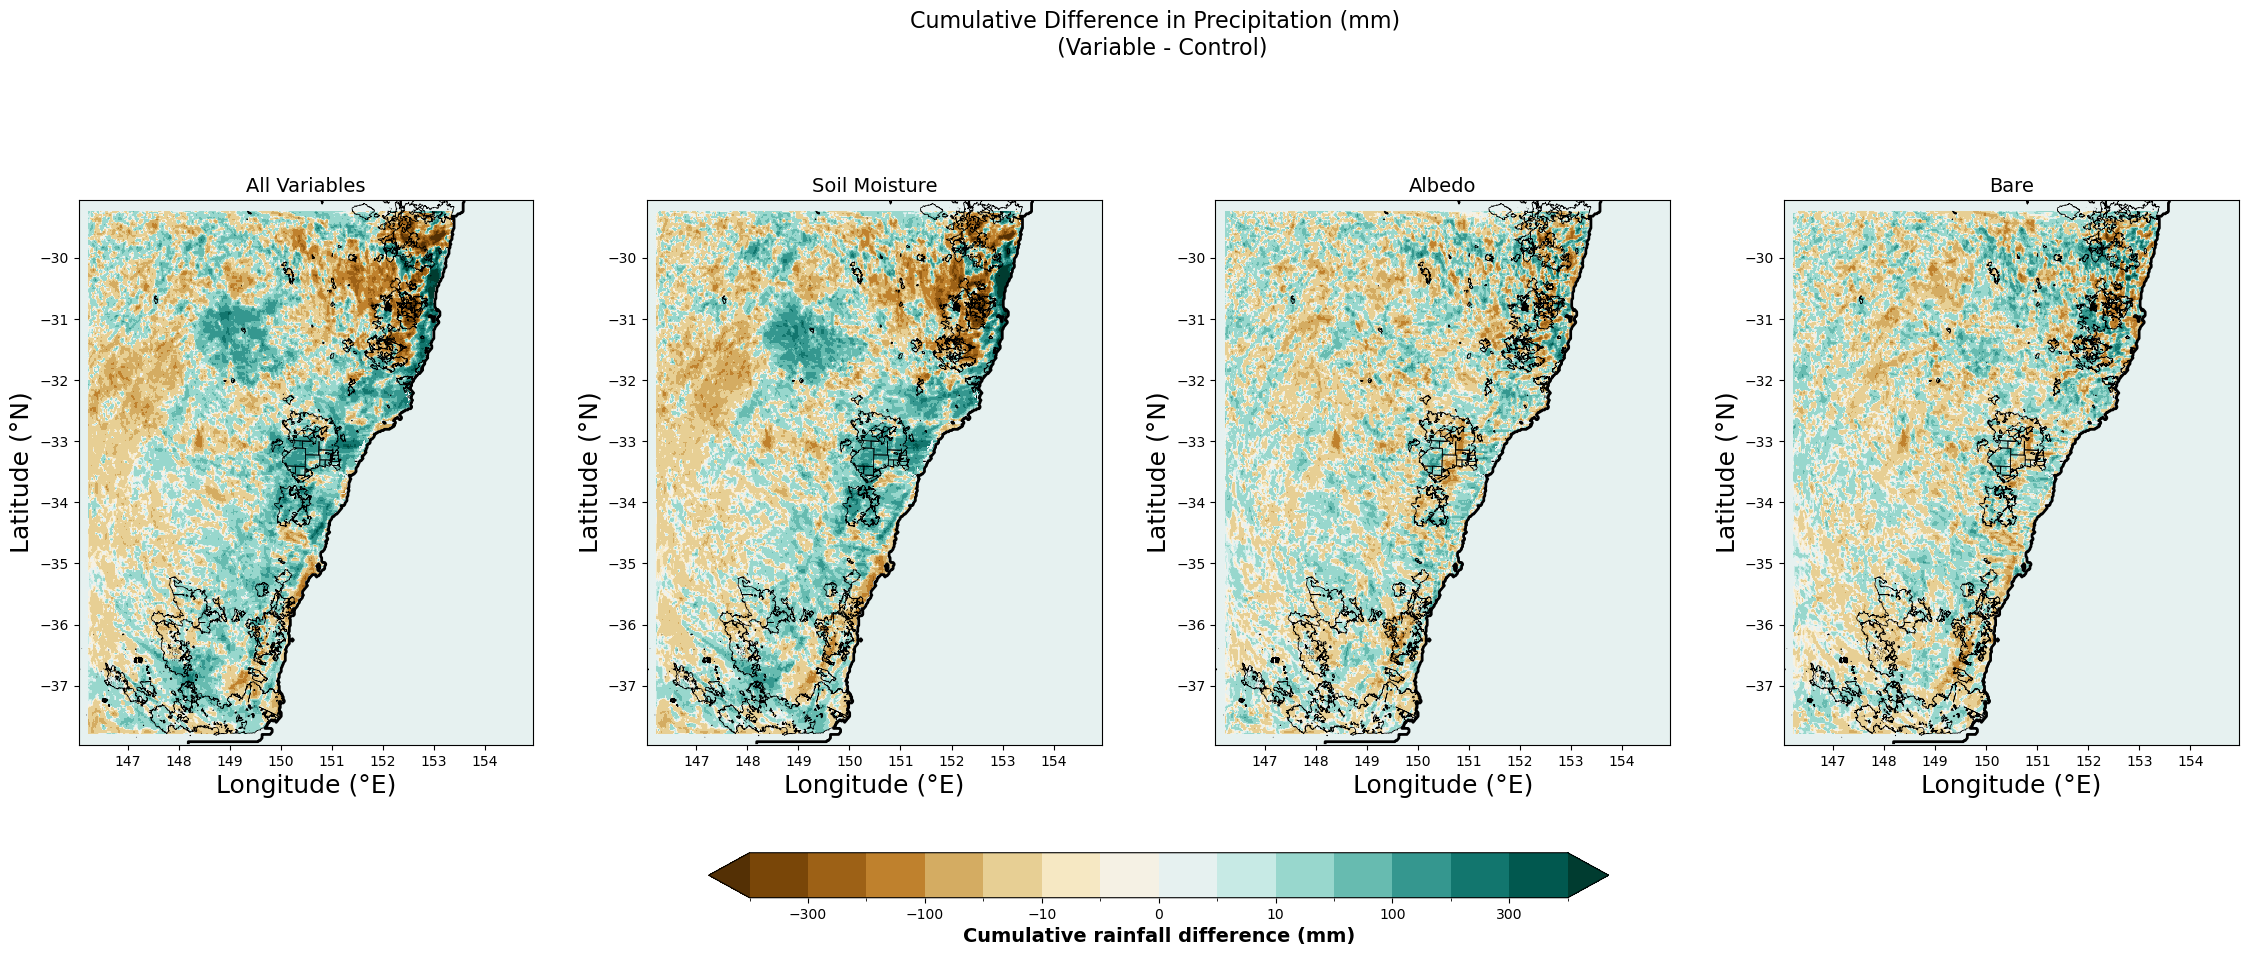

In [20]:
#individual component difference

totals_subset = {
    "All Variables": totals["All Variables"],
    "Soil Moisture": totals["SM"],
    "Albedo": totals["Albedo"],
    "Bare": totals["Bare"],
    "Control": totals["Control"],  #reference
}

names = list(totals_subset.keys())
ref_name = "Control"

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,6))
axes = axes.flatten()

cbar_ax = None
plot_idx = 0

for name in names:
    if name == ref_name:
        continue

    diff = totals_subset[name] - totals_subset[ref_name]
    ax = axes[plot_idx]

    mesh = diff.plot(
        ax=ax,
        cmap="BrBG",
        center=0,
        levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
        extend="both",
        add_colorbar=False
    )

    if plot_idx == 0:
        cbar_ax = mesh

    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.set_title(f"{name}", fontsize = 14)
    ax.set_xlabel("Longitude (°E)", fontsize=18)
    ax.set_ylabel("Latitude (°N)", fontsize=18)

    plot_idx += 1

fig.subplots_adjust(left=0.05,
                    right=0.95, 
                    top=1, 
                    bottom=-0.5, 
                    hspace=0.1,
                    wspace=0.25)

#shared colorbar
cbar = fig.colorbar(
    cbar_ax, ax=axes, 
    orientation='horizontal',
    fraction=0.05,  
    pad=0.12
    # label="Cumulative rainfall difference (mm)"
)
# cbar.ax.tick_params(labelsize=14)
cbar.set_label("Cumulative rainfall difference (mm)", fontsize=14, fontweight = 'bold')


fig.suptitle("Cumulative Difference in Precipitation (mm) \n (Variable - Control)", fontsize=16)
# plt.savefig("/g/data/ng72/as9583/figures/precip_diff_seminar.png", dpi=300, bbox_inches="tight")
plt.show()
